# Coding Challange

## Preprocess the data

### Apply setting 

In [2]:
# load libraries
import numpy as np
import pandas as pd
import sys, time, os
from datetime import date
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import arff 

# determine the path to the source folder
pth_to_src = 'C:/DEV/Premium/src/'

# get date of today:
# Reason: Create outputfolder with current date to store plots and trained model if wanted.
today = '20230614' #date.today().strftime('%Y%m%d')

# input folder:
input_folder = pth_to_src + 'input/'

# output folder:
output_folder = pth_to_src + 'output/' + today + '/' # with date of today. This way a daily history of results can be automatically stored.
output_folder_plots = output_folder+'plots/'  
output_folder_model = output_folder+'model/'

# create output_folder if not existant:
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_plots, exist_ok=True)
os.makedirs(output_folder_model, exist_ok=True)
# load utility functions
sys.path.append(pth_to_src+'/utils/')
from utility import *
# reload functions from utility
from importlib import reload
reload(sys.modules['utility'])

# set random seed for reproduceability
np.random.seed(888) 

### Load, clean, prepare and check the data

The dataset freMTPL2freq contains 678,013 individual car insurance policies and for each policy we have 12 risk features observed mostly on one year which can be described as follows:

- IDpol: ID des Vertrags 
- ClaimNb: Anzahl Schäden im Versicherungszeitraum
- Exposure: Länge des Versicherungszeitraums (in Jahren) [Komponente der abhängigen Variable] 
- Area: Area-Code des Versicherungsnehmers [unabhängige Variable] 
- VehPower: Leistung des versicherten Kfz [unabhängige Variable] 
- VehAge: Alter des versicherten Kfz [unabhängige Variable] 
- DrivAge: Alter des Versicherungsnehmers [unabhängige Variable] 
- BonusMalus: Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse) [unabhängige Variable] 
- VehBrand: Marke des versicherten Kfz [unabhängige Variable] • VehGas: Antrieb des versicherten Kfz [unabhängige Variable] 
- Density: Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers [unabhängige Variable] 
- Region: Region des Versicherungsnehmers [unabhängige Variable]

The dataset freMTPL2sev contains claim amounts for 26,639 motor third-part liability policies: 
- IDpol: ID des Vertrags
- ClaimAmount: Höhe der einzelnen Schadenaufwände (mehrere Einträge pro Vertrag, falls im Zeitraum mehrere Schäden vorhanden waren.) [Komponente der abhängigen Variable.



In [3]:
# read the raw data sets
data_freq = arff.load(input_folder+'freMTPL2freq.arff') 
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]) 

data_sev = arff.load(input_folder+'freMTPL2sev.arff') 
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

df_freq.shape

(678013, 12)

In [4]:
# aggregate df_sev to sum up the claim amounts per policy (IDpol):
df_sev = df_sev.groupby('IDpol').sum("ClaimAmount")
df_sev.reset_index(inplace =True)
df_sev.shape

(24950, 2)

In [5]:
# merge the data sets 
df = pd.merge(df_freq, df_sev,on='IDpol',how='left')
# fill missing ClaimAmount with 0:
df.ClaimAmount = df.ClaimAmount.fillna(0)
# clean workspace
del data_freq, df_freq, data_sev, df_sev
df.shape

(678013, 13)

In [6]:
# Use upper limit for claim amount
# Reason: extremely large claim amount may be due to data errors
MX_CLAIM_AMOUNT = 250000
print("Number of observations above %s: %s before cleaning." % (MX_CLAIM_AMOUNT,sum(df["ClaimAmount"]>MX_CLAIM_AMOUNT)))
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=MX_CLAIM_AMOUNT)
print("Number of observations above %s: %s after cleaning." % (MX_CLAIM_AMOUNT,sum(df["ClaimAmount"]>MX_CLAIM_AMOUNT)))

Number of observations above 250000: 12 before cleaning.
Number of observations above 250000: 0 after cleaning.


In [7]:
# create target variable:
# yearly Premium amount per client
df['Premium'] = df.ClaimAmount / df.Exposure
df.head(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Premium
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',0.0,0.0
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0


In [8]:
# define the list of feature variables: x_vars
# numeric x_vars:
x_vars_numeric =  [ 'VehPower', 'VehAge', 'DrivAge','BonusMalus', 'Density']
# categorial x_vars:
x_vars_cat     = [ 'Area','VehBrand', 'VehGas', 'Region']
x_vars = x_vars_numeric + x_vars_cat

In [9]:
# Show the number of rows and columns of the dataframe:
df.shape

(678013, 14)

In [10]:
# Check the number of missing values of each column:
pd.DataFrame([df.isna().sum(),df.isna().mean()],index=['Number of missing values', 'Rate of missing values']).T

,Number of missing values,Rate of missing values
IDpol,0.0,0.0
ClaimNb,0.0,0.0
Exposure,0.0,0.0
Area,0.0,0.0
VehPower,0.0,0.0
VehAge,0.0,0.0
DrivAge,0.0,0.0
BonusMalus,0.0,0.0
VehBrand,0.0,0.0
VehGas,0.0,0.0


In [11]:
# Show basic summary statistics of the data:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Premium
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,77.966306,3.444676e+02
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,1746.489506,2.817640e+04
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000,0.000000e+00
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000,0.000000e+00
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000,0.000000e+00
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000,0.000000e+00
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,250000.000000,1.830737e+07


### Descriptive statistics of target variable 

#### Frequency of number of Claims

col_0,count,ratio
ClaimNb,,
0.0,643953,0.949765
1.0,32178,0.047459
2.0,1784,0.002631
3.0,82,0.000121
4.0,7,0.000010
5.0,2,0.000003
6.0,1,0.000001
8.0,1,0.000001
9.0,1,0.000001


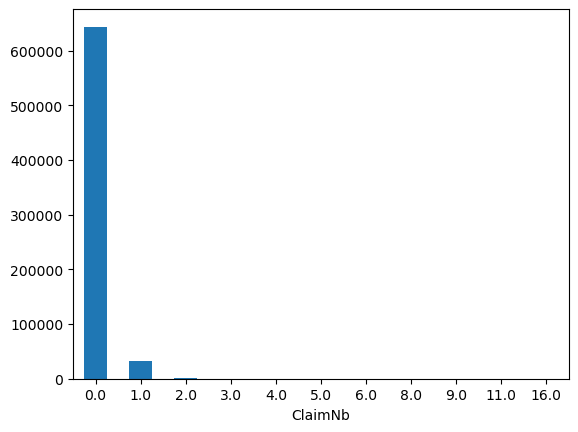

In [12]:
y_tab = pd.crosstab(df['ClaimNb'], columns='count')
y_tab['ratio'] = y_tab['count']/y_tab['count'].sum()
y_tab['count'].plot(kind='bar')
plt.tick_params('x', labelrotation=0)
y_tab

#### Plot Exposure

Text(0.5, 1.0, 'Histogram of the exposures')

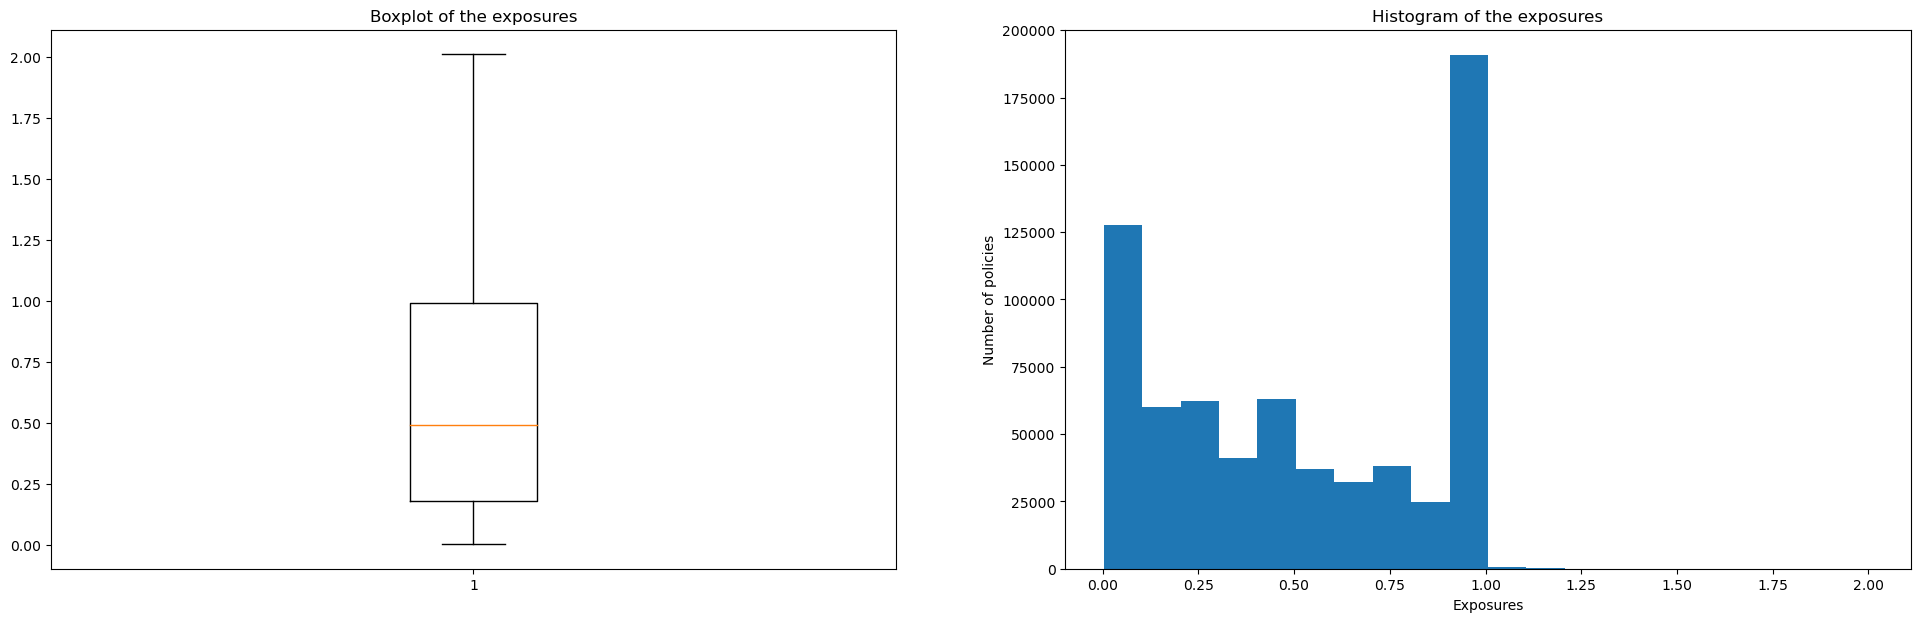

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (24, 7))

axs[0].boxplot(df['Exposure'])
axs[0].set_title('Boxplot of the exposures')

axs[1].hist(df['Exposure'], bins = 20)
axs[1].set_xlabel('Exposures')
axs[1].set_ylabel('Number of policies')
axs[1].set_title('Histogram of the exposures')


#### Plot claim amount

Text(0.5, 1.0, 'Histogram of ClaimAmount > 0 (log scale)')

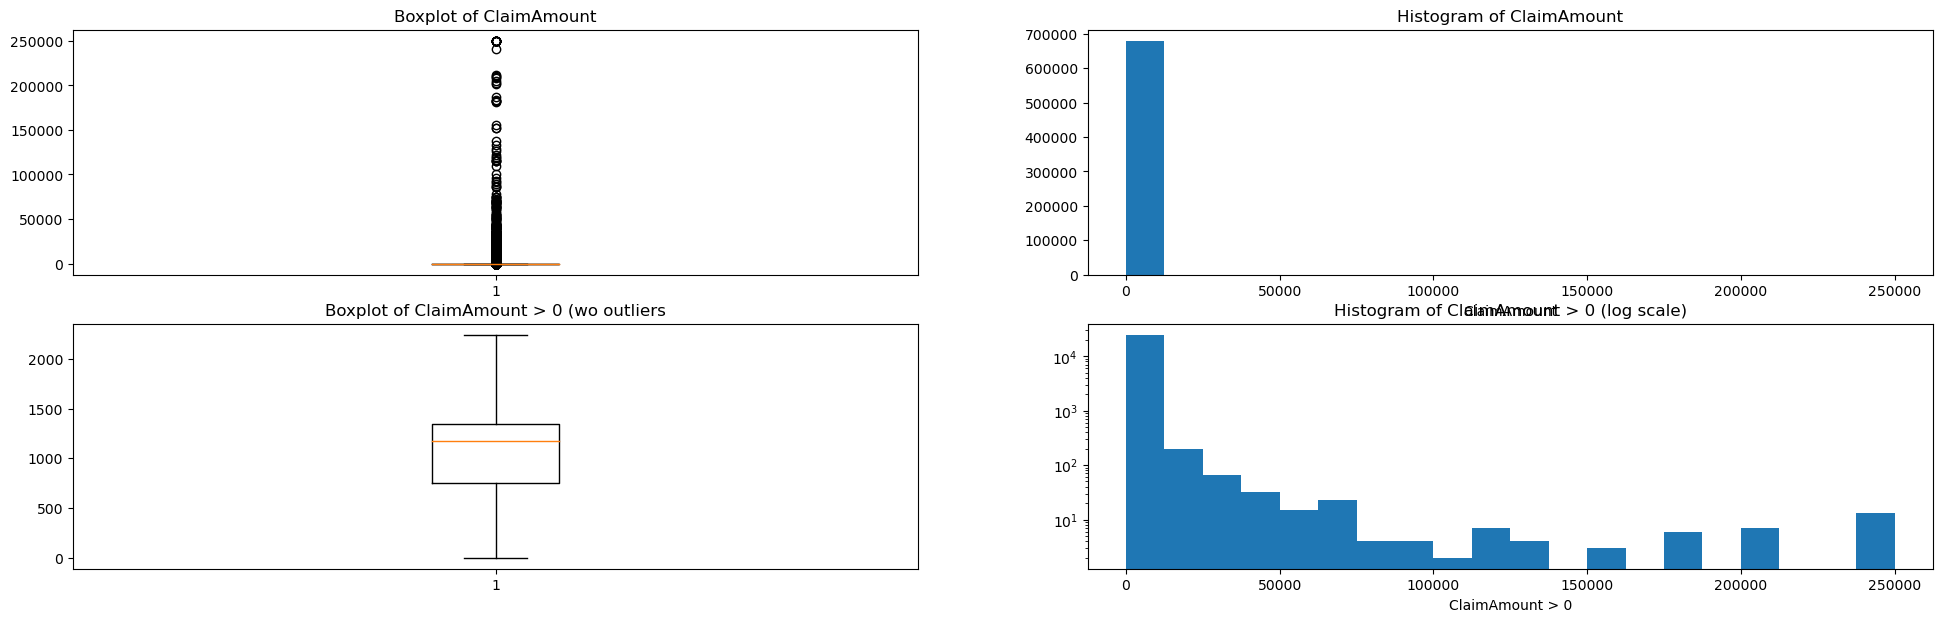

In [14]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (24, 7))

axs[0,0].boxplot(df['ClaimAmount'])
axs[0,0].set_title('Boxplot of ClaimAmount')

axs[0,1].hist(df['ClaimAmount'], bins = 20)
axs[0,1].set_xlabel('ClaimAmount')
axs[0,1].set_title('Histogram of ClaimAmount')


axs[1,0].boxplot(df.loc[df['ClaimAmount']>0,'ClaimAmount'], showfliers =0)
axs[1,0].set_title('Boxplot of ClaimAmount > 0 (wo outliers')

axs[1,1].hist(df.loc[df['ClaimAmount']>0,'ClaimAmount'], bins =20,  log=True)
axs[1,1].set_xlabel('ClaimAmount > 0')
axs[1,1].set_title('Histogram of ClaimAmount > 0 (log scale)')


#### Frequency of premium larger than zero

col_0,count,ratio
0,653069,0.96321
> 0,24944,0.03679


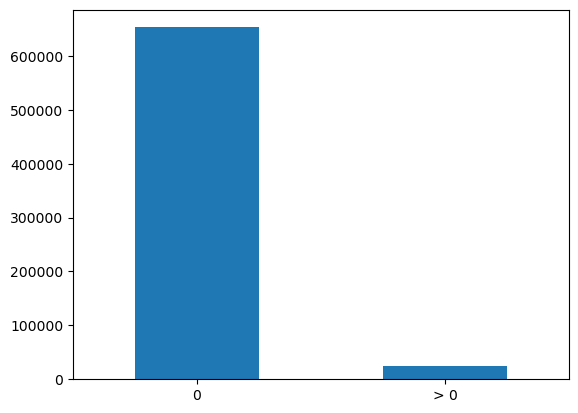

In [15]:
# Premium is the yearly Premium amount per customer
y_tab = pd.crosstab(df['Premium']>0, columns='count')
y_tab.index = ['0','> 0']
y_tab['ratio'] = y_tab['count']/y_tab['count'].sum()
y_tab['count'].plot(kind='bar')
plt.tick_params('x', labelrotation=0)
y_tab

#### Density plot of premium (yearly damage amount per customer)

Text(0.5, 1.0, 'Histogram of Premium > 0 (log scale)')

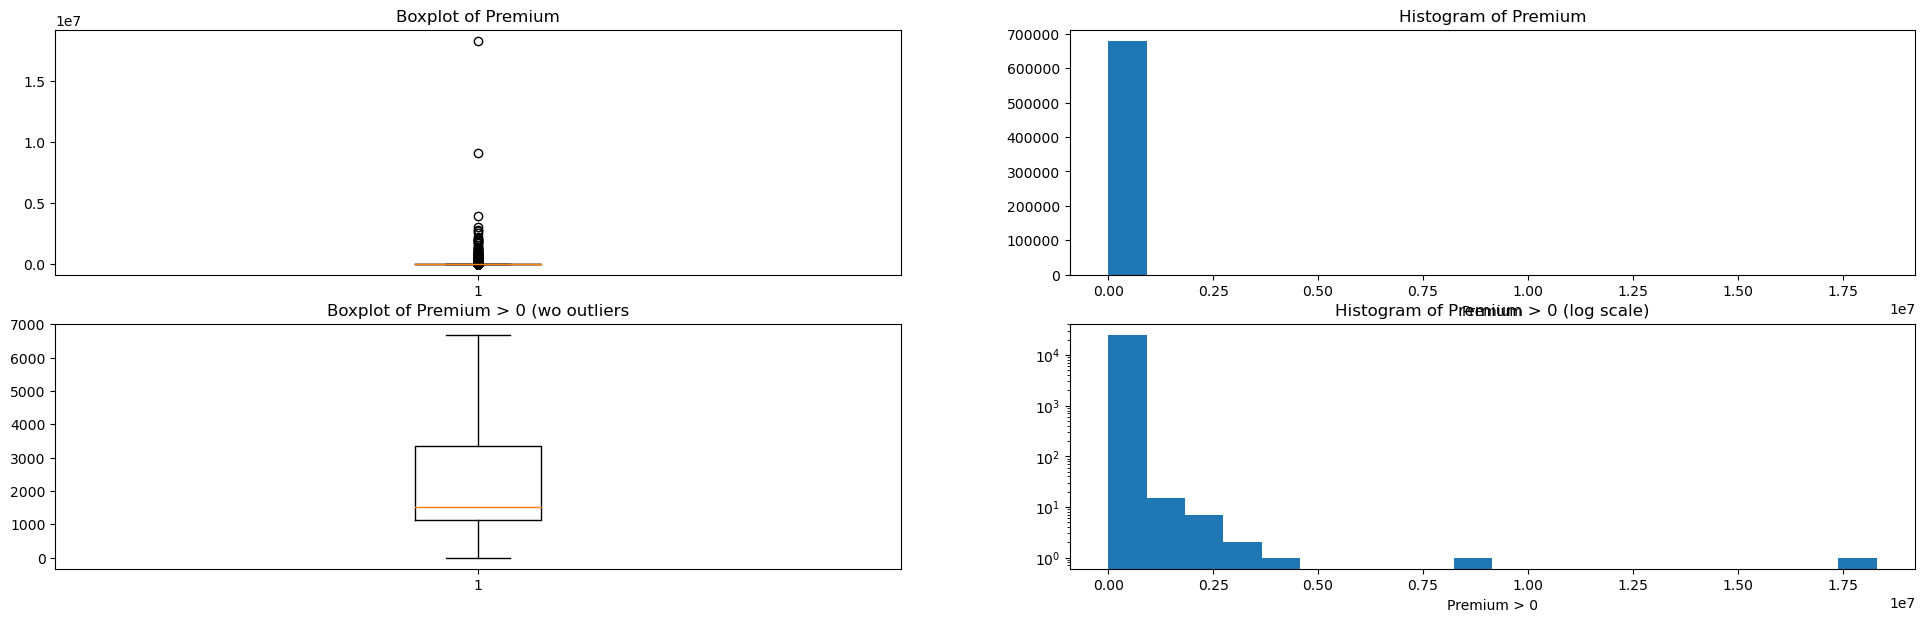

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (24, 7))

axs[0,0].boxplot(df['Premium'])
axs[0,0].set_title('Boxplot of Premium')

axs[0,1].hist(df['Premium'], bins = 20)
axs[0,1].set_xlabel('Premium')
axs[0,1].set_title('Histogram of Premium')


axs[1,0].boxplot(df.loc[df['Premium']>0,'Premium'], showfliers =0)
axs[1,0].set_title('Boxplot of Premium > 0 (wo outliers')

axs[1,1].hist(df.loc[df['Premium']>0,'Premium'], bins =20,  log=True)
axs[1,1].set_xlabel('Premium > 0')
axs[1,1].set_title('Histogram of Premium > 0 (log scale)')


####  Plot Premium (log-transformed) 

Text(0.5, 1.0, 'Histogram of log( Premium + 1)')

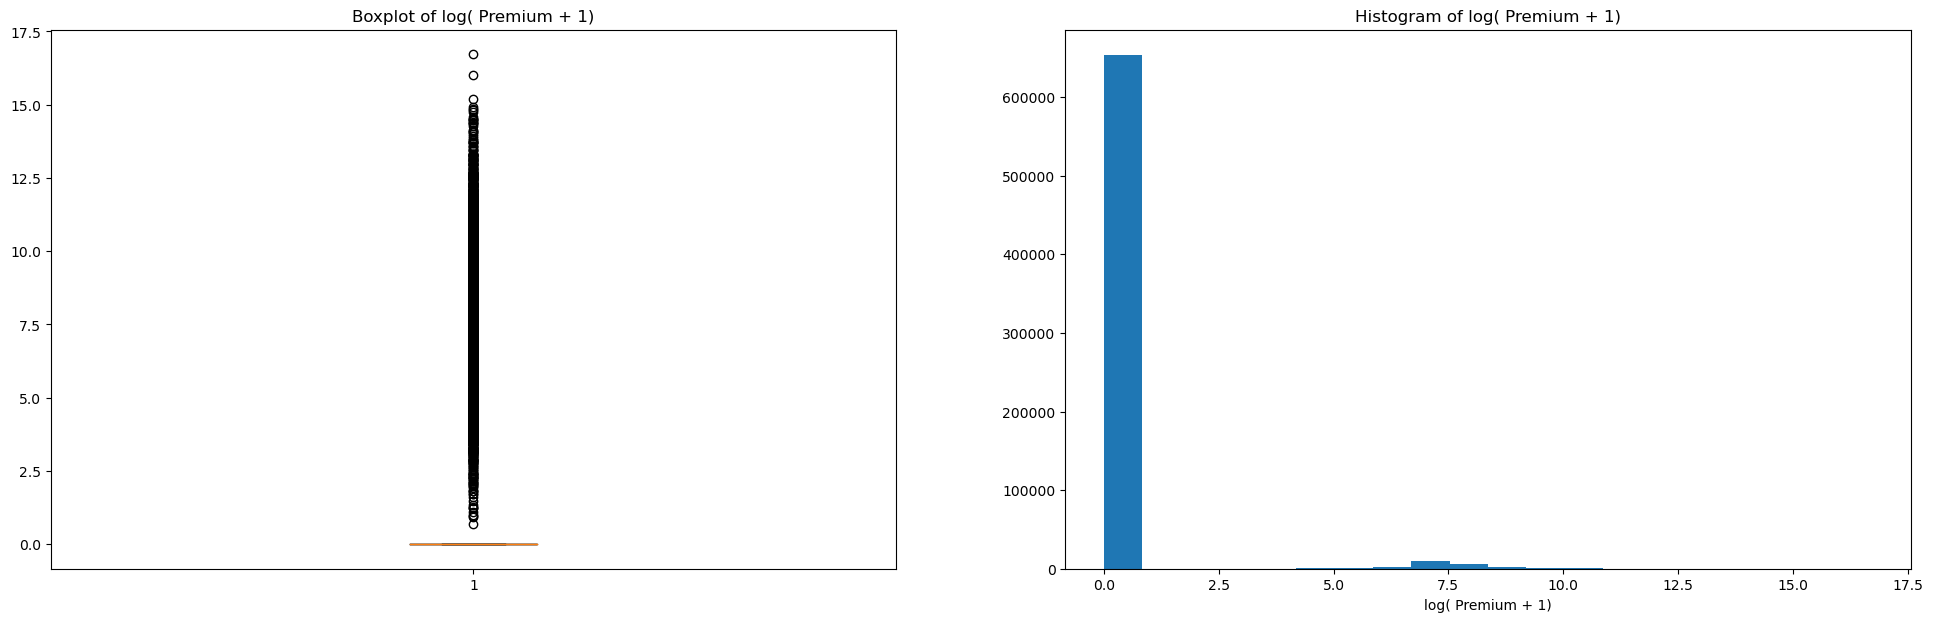

In [17]:
# add + 1 to Premium before the log-transformation to avoid computation of log of zero.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (24, 7))
axs[0].boxplot(np.log(df['Premium']+1))
axs[0].set_title('Boxplot of log( Premium + 1)')

axs[1].hist(np.log(df['Premium'] + 1), bins = 20)
axs[1].set_xlabel('log( Premium + 1)')
axs[1].set_title('Histogram of log( Premium + 1)')

####  Plot Premium larger than zero (log-transformed) 

Text(0.5, 1.0, 'Histogram of log( Premium )')

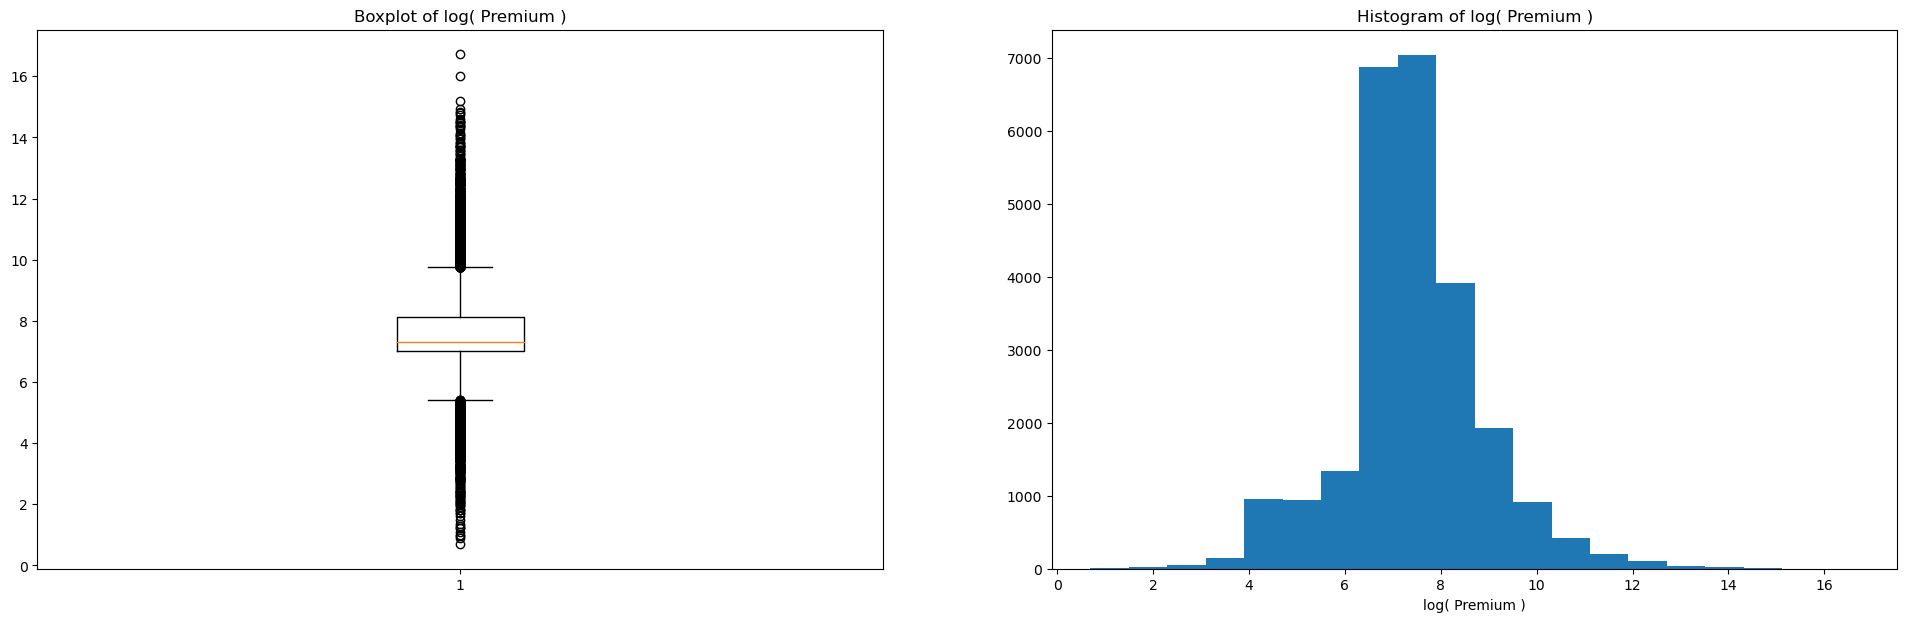

In [18]:
# add + 1 to Premium before the log-transformation to avoid computation of log of zero.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (24, 7))
axs[0].boxplot(np.log(df.loc[df['Premium']>0,'Premium']+1))
axs[0].set_title('Boxplot of log( Premium )')

axs[1].hist(np.log(df.loc[df['Premium']>0,'Premium']+1), bins = 20)
axs[1].set_xlabel('log( Premium )')
axs[1].set_title('Histogram of log( Premium )')

### Descriptive statistics of features

#### Barplots of categorial variables

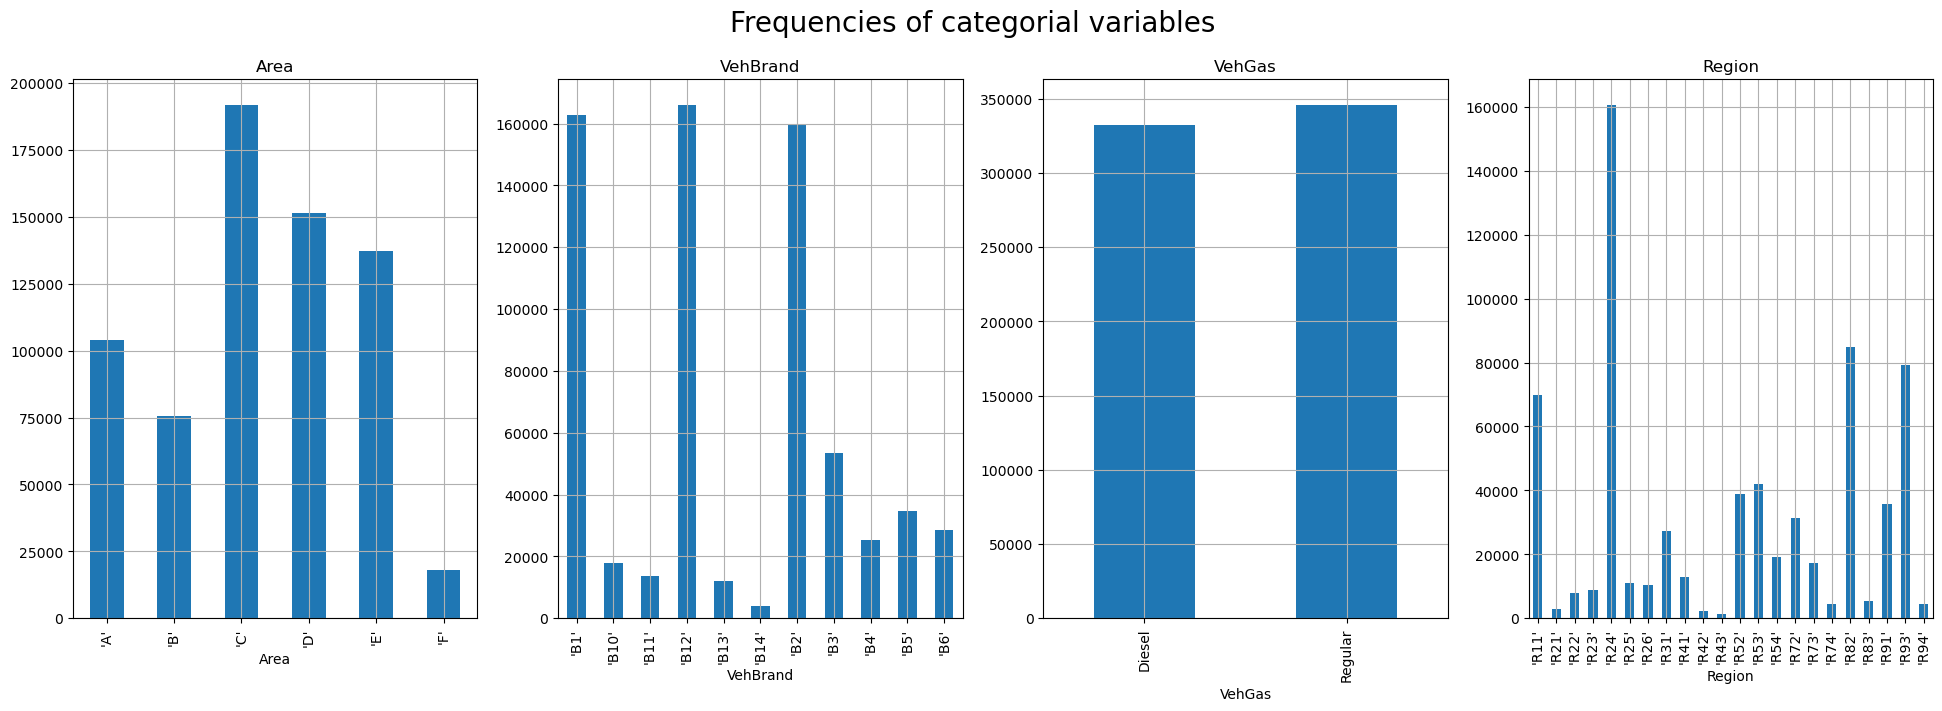

In [257]:
fig, axs = plt.subplots(nrows=1, ncols=len(x_vars_cat), figsize = (24, 7))
fig.suptitle('Frequencies of categorial variables', fontsize=20)
for ix, i in enumerate(x_vars_cat):
        df.groupby([i]).size().plot(kind='bar', ax= axs[ix])
        axs[ix].set_title(f'{i}')
        axs[ix].grid()

####  Boxplots of numeric features

Text(0.5, 0.98, '')

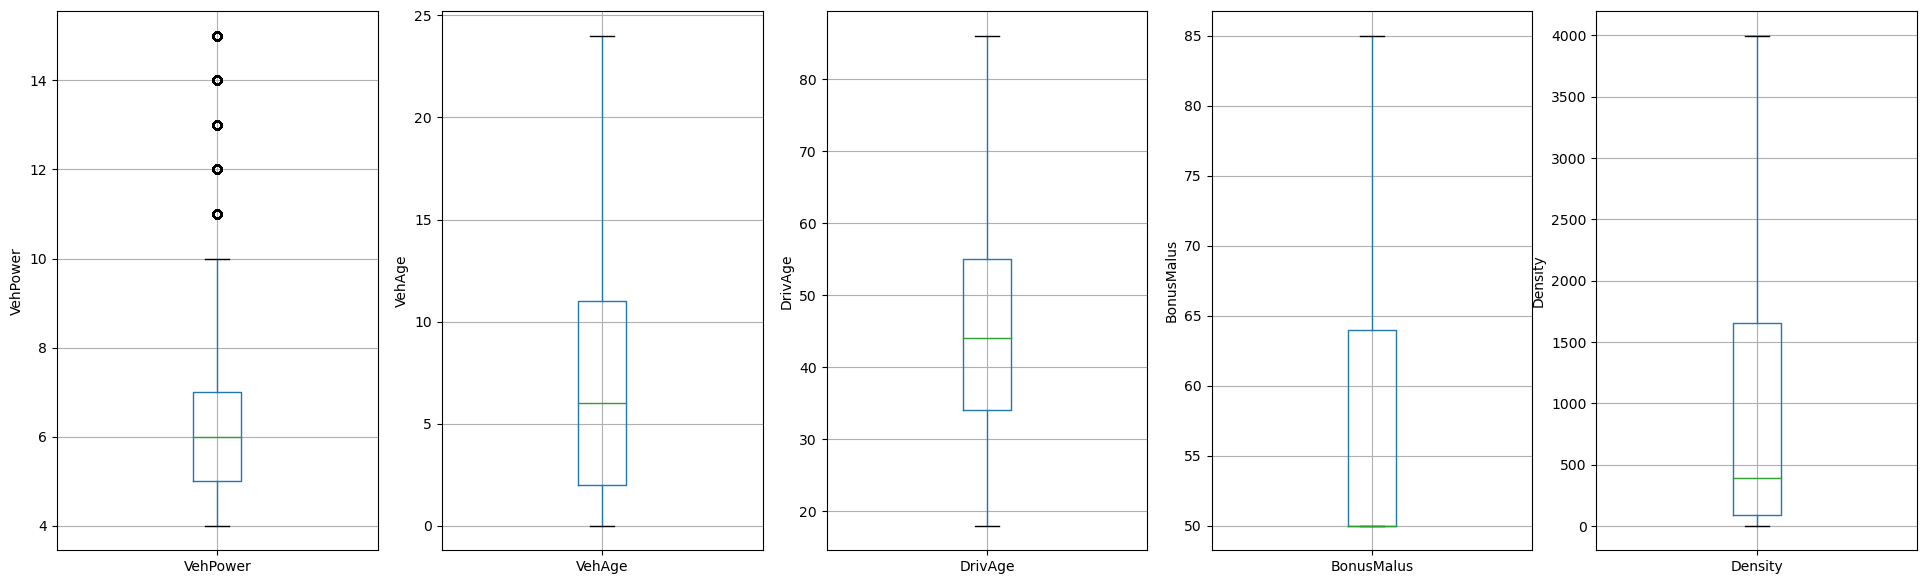

In [259]:
# Show boxplots of numeric features: 
fig, axs = plt.subplots(nrows=1, ncols=len(x_vars_numeric), figsize = (24, 7))
for  j, m in enumerate(x_vars_numeric):
    g = df[[m]].boxplot(showfliers=(j==0), ax= axs[j])
    g.set_ylabel(m)
fig.suptitle('')

####  Boxplots of numeric features in relationship to categorial variables

Text(0.5, 0.98, '')

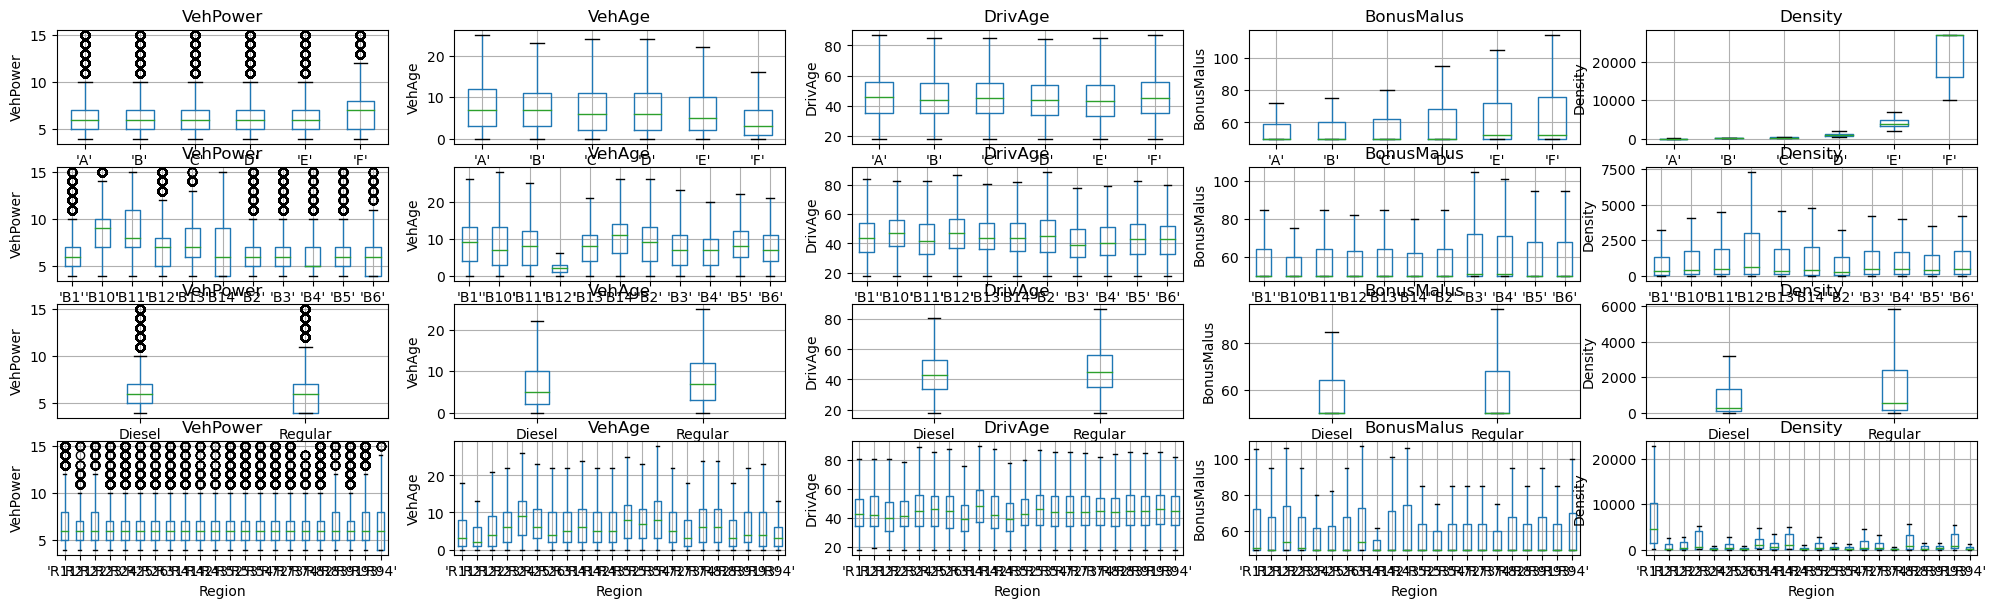

In [21]:
# Show boxplots of numeric features in relationship to categorial variables: 
fig, axs = plt.subplots(nrows=len(x_vars_cat), ncols=len(x_vars_numeric), figsize = (24, 7))
for  j, m in enumerate(x_vars_numeric):
    for  i, n in enumerate(x_vars_cat):
        g = df[[m,n]].boxplot(showfliers=(j==0), ax= axs[i,j],by=n)
        g.set_ylabel(m)
        g.set_xlabel(n)
fig.suptitle('')

### Explorative analysis of the data

#### Premium per categorial variable

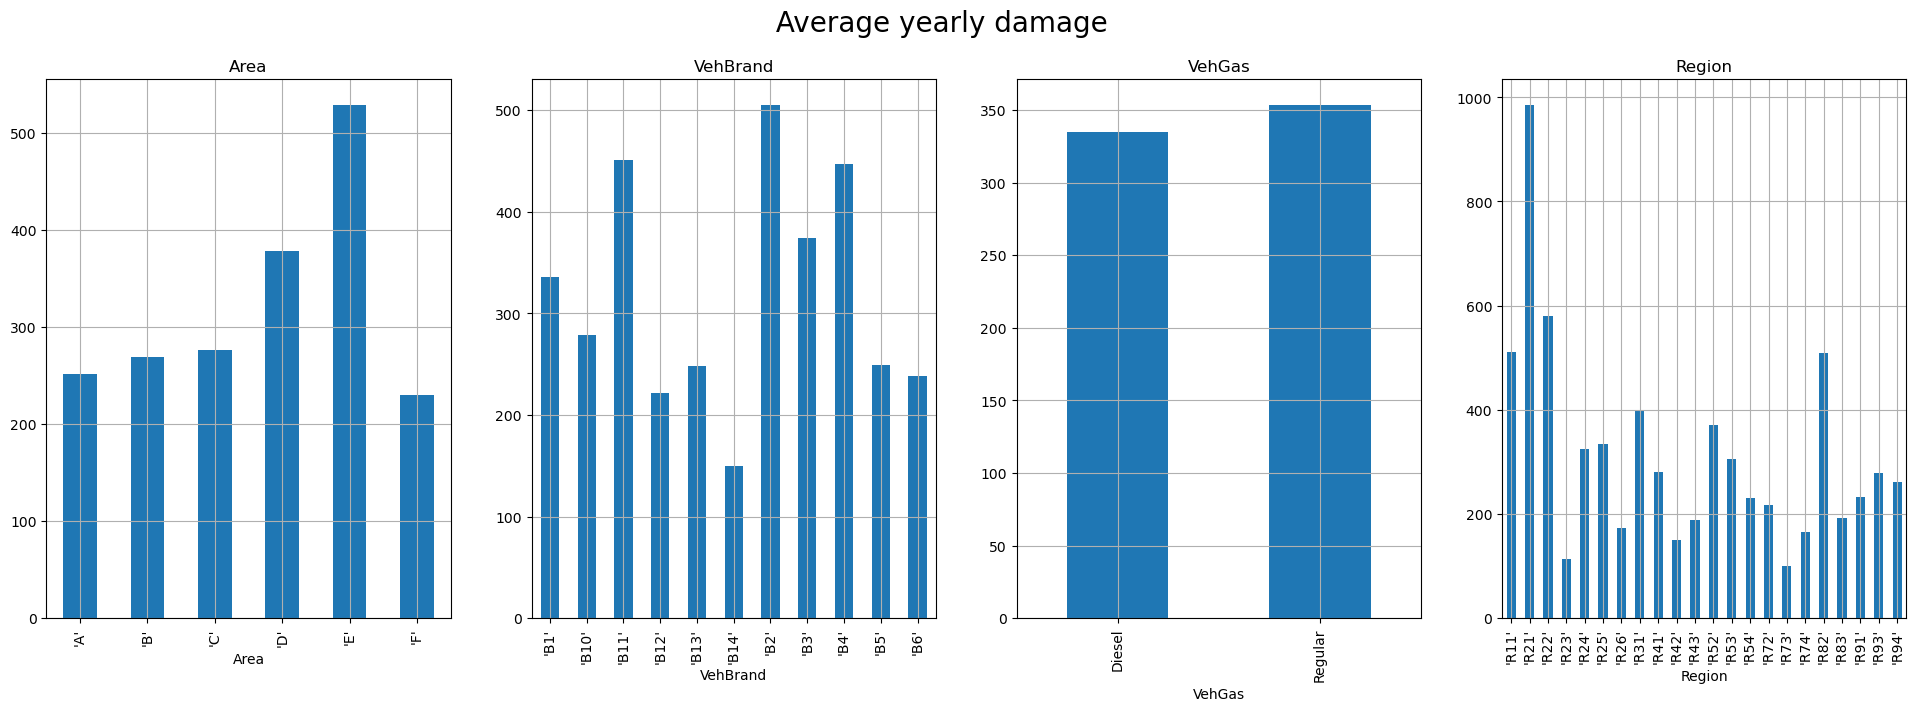

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(x_vars_cat), figsize = (24, 7))
fig.suptitle('Premium', fontsize=20)
for ix, i in enumerate(x_vars_cat):
        df.groupby(i)['Premium'].mean().plot(kind='bar', ax= axs[ix])
        axs[ix].set_title(f'{i}')
        axs[ix].grid()

#### Categorial combinations with highest Premium

In [260]:
# Show the Premium aggregates per x_var_cat group
damage_agg =df.copy().groupby(x_vars_cat)['Premium'].aggregate([np.mean, np.size])
pd.options.display.float_format =  '{:,.0f}'.format
# show combinations (with at least 10 observations) with highest average damages:
damage_agg[damage_agg['size']>=10].sort_values(by= 'mean', ascending=False).head(10)

mean  size
Area VehBrand VehGas  Region             
'D'  'B1'     Diesel  'R22'  17,972   142
'C'  'B10'    Diesel  'R22'  17,282    15
'A'  'B2'     Diesel  'R11'  11,529    98
'B'  'B2'     Regular 'R83'  10,012    53
'E'  'B2'     Regular 'R11'   8,590  2181
'C'  'B13'    Regular 'R31'   8,040    38
     'B11'    Regular 'R72'   7,886    76
     'B12'    Diesel  'R25'   7,406   276
'A'  'B12'    Diesel  'R21'   6,589   426
'D'  'B4'     Diesel  'R31'   5,098   359

#### Categorial combinations with lowest Premium

In [23]:
# show combinations (with at least 10 observations) with lowest Premium:
damage_agg[damage_agg['size']>=10].sort_values(by= 'mean', ascending=False).tail(10)

mean  size
Area VehBrand VehGas  Region            
'A'  'B4'     Regular 'R22'      0    15
              Diesel  'R73'      0    34
'D'  'B10'    Diesel  'R22'      0    12
                      'R26'      0    26
'E'  'B13'    Regular 'R23'      0    23
'A'  'B4'     Diesel  'R94'      0    23
                      'R93'      0    34
     'B11'    Regular 'R73'      0    18
'D'  'B10'    Diesel  'R73'      0    22
'B'  'B12'    Diesel  'R43'      0    69

In [24]:
# reset display settings
pd.reset_option('^display.', silent=True)

#### Scatterplots of Premium and numeric features

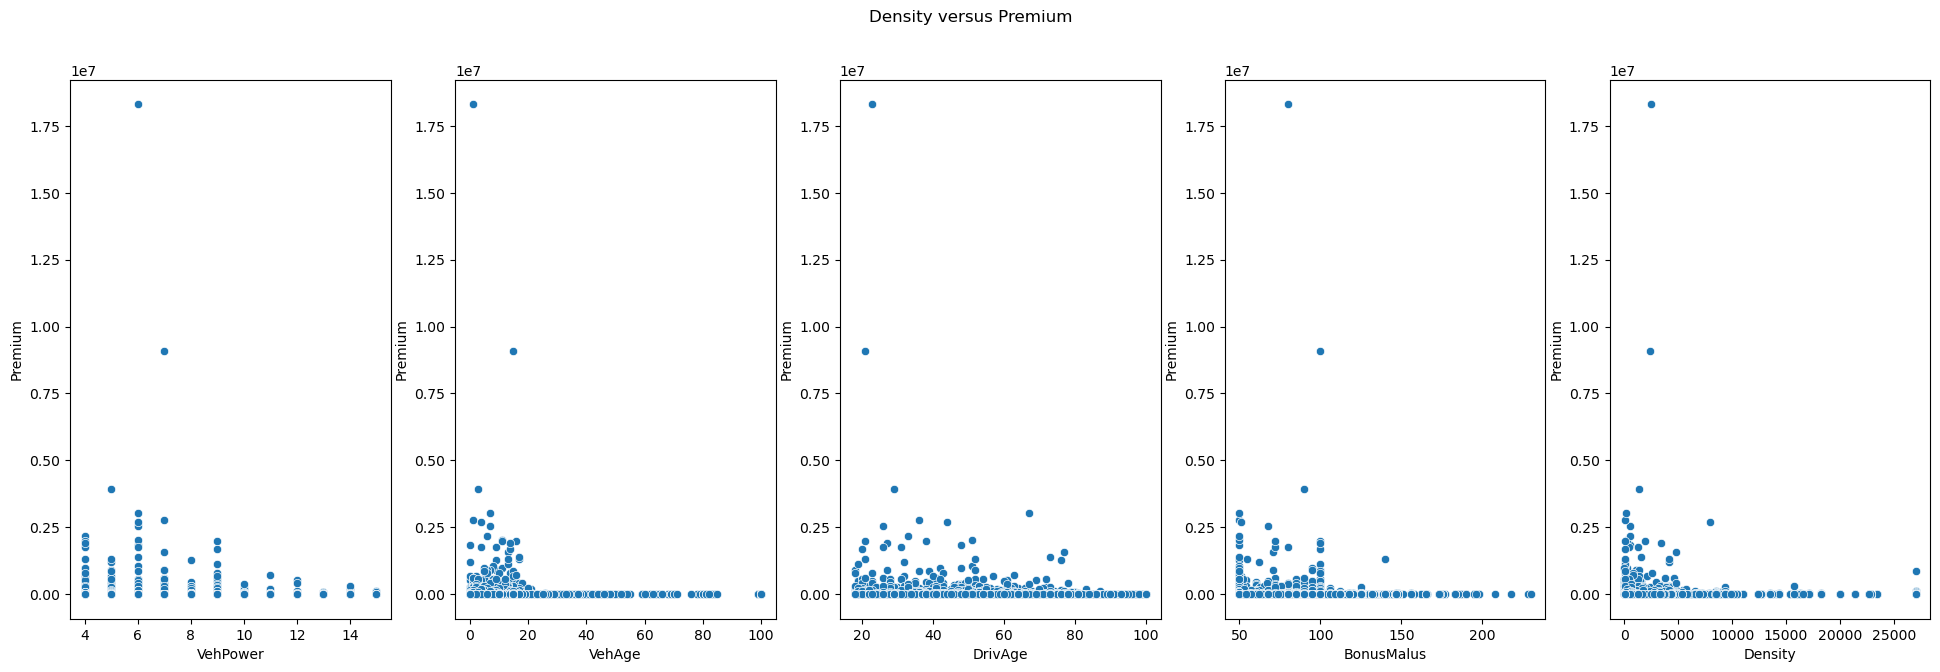

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(x_vars_numeric), figsize = (24, 7))
for  i, m in enumerate(x_vars_numeric):
    g = sns.scatterplot(x=m,y='Premium', data=df, ax = axs[i])
    g.set_ylabel('Premium')
    g.set_xlabel(m)    
    axs[i] = plt.suptitle(f'{m} versus Premium')

#### Test for correlations

In [25]:
from scipy.stats import  kendalltau, spearmanr, pearsonr
def correlation_tests(df, x1_name, x2_name, alpha = 0.05):
    x1 = df[x1_name]
    x2 = df[x2_name]
    print("----------------------------------------------------------------------------------")
    stat, p = spearmanr(x1,x2)
    print("Spearman      correlation of %s and %s: %.1f. The p-value is %.3f " % (x1_name, x2_name,stat, p)) 
    stat, p = pearsonr(x1,x2)
    print("Pearson       correlation of %s and %s: %.1f. The p-value is %.3f " % (x1_name, x2_name,stat, p))      
    stat, p = kendalltau(x1,x2)
    print("Kendall\'s tau correlation of %s and %s: %.1f. The p-value is %.3f " % (x1_name, x2_name,stat, p))
    print("----------------------------------------------------------------------------------") 
    
for  i, m in enumerate(x_vars_numeric):   
    correlation_tests(df,'Premium', m)  


----------------------------------------------------------------------------------
Spearman      correlation of Premium and VehPower: 0.0. The p-value is 0.057 
Pearson       correlation of Premium and VehPower: -0.0. The p-value is 0.597 


c:\Users\G\anaconda3\envs\py311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Kendall's tau correlation of Premium and VehPower: 0.0. The p-value is 0.057 
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Spearman      correlation of Premium and VehAge: 0.0. The p-value is 0.000 
Pearson       correlation of Premium and VehAge: 0.0. The p-value is 0.609 
Kendall's tau correlation of Premium and VehAge: 0.0. The p-value is 0.000 
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Spearman      correlation of Premium and DrivAge: -0.0. The p-value is 0.000 
Pearson       correlation of Premium and DrivAge: -0.0. The p-value is 0.000 
Kendall's tau correlation of Premium and DrivAge: -0.0. The p-value is 0.000 
----------------------------------------------------------------------------------
---------------------------------------------

####  Heatmap of correlations 

C:\Users\G\AppData\Local\Temp\ipykernel_264\1171392024.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr1 = df[['Premium']+ x_vars].corr(method='pearson', min_periods=1)


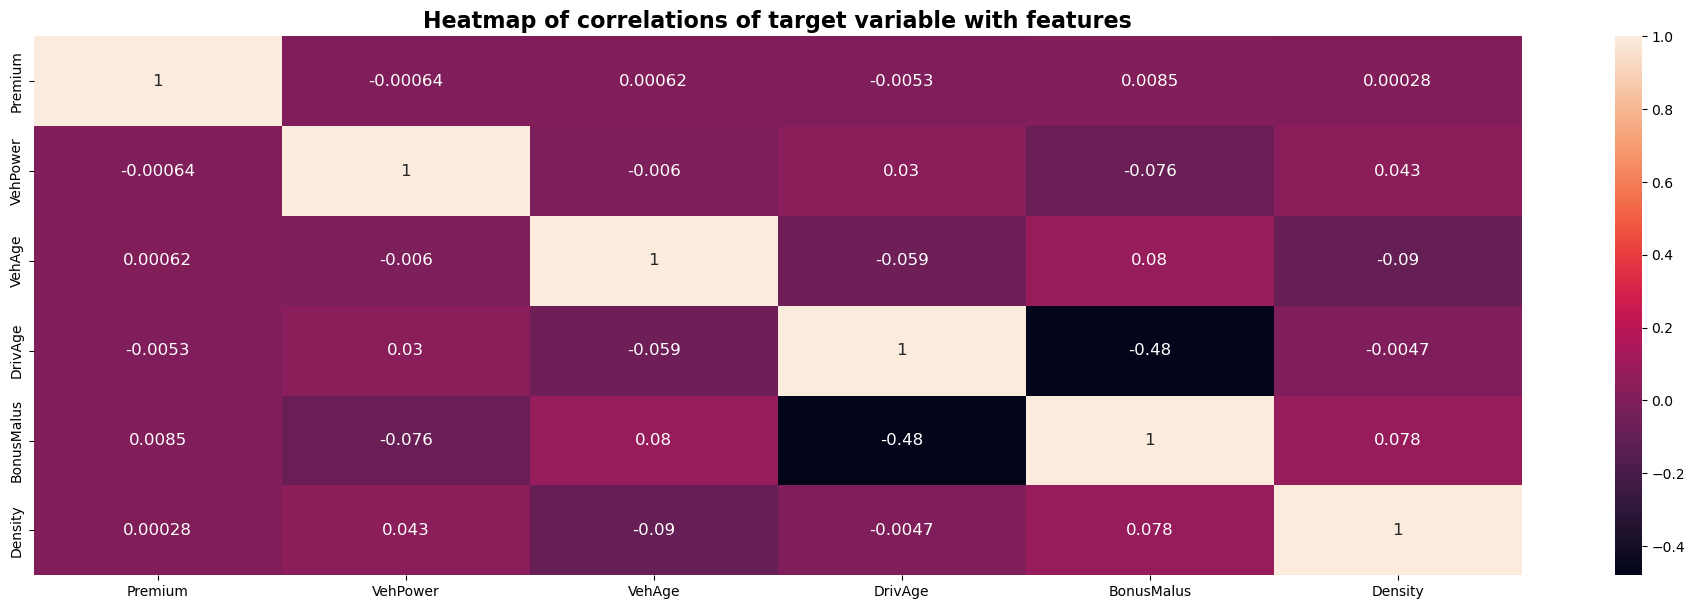

In [26]:
fig,ax = plt.subplots(nrows =1, ncols = 1, figsize = (24,7))
corr1 = df[['Premium']+ x_vars].corr(method='pearson', min_periods=1)
sns.heatmap(corr1, annot = True, annot_kws={"fontsize":12})
plt.title('Heatmap of correlations of target variable with features', fontsize=16, weight = 'bold')
plt.setp(ax.get_xticklabels(), fontsize=10, weight = 'normal');
plt.setp(ax.get_yticklabels(), fontsize=10, weight = 'normal');
plt.show()

The correlations of the explanatory with the target variable Premium appear to be quit low. 

## Forecasting analysis

Choose the root mean squared error (RMSE) and the mean absolute error as metric (MAE) for model training and comparison. Both RMSE and MAE are standard measures for regression type forecasting. Additionally, we will compute a model's implied total claim amount and compare it to the observed value as an illustrative measure. 

### Prepare features

In [62]:
df1 = df[['Premium']+x_vars].copy()

# scale feature variables
if 1:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    ## scale the data set:
    df1[x_vars_numeric] = scaler.fit_transform(df1[x_vars_numeric])

# one hot / dummy encoding
if 1:
    # Add dummy variables for the categorial features :
    for  i, m in enumerate(x_vars_cat):
        df1 = pd.get_dummies(data=df1, columns= [m],prefix='',prefix_sep='', drop_first=True)

df1.head(5)


,Premium,VehPower,VehAge,DrivAge,BonusMalus,Density,'B','C','D','E',...,'R53','R54','R72','R73','R74','R82','R83','R91','R93','R94'
0,0.0,0.090909,0.00,0.451220,0.0,0.045039,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.090909,0.00,0.451220,0.0,0.045039,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.181818,0.02,0.414634,0.0,0.001963,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.272727,0.00,0.341463,0.0,0.002778,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0.272727,0.00,0.341463,0.0,0.002778,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


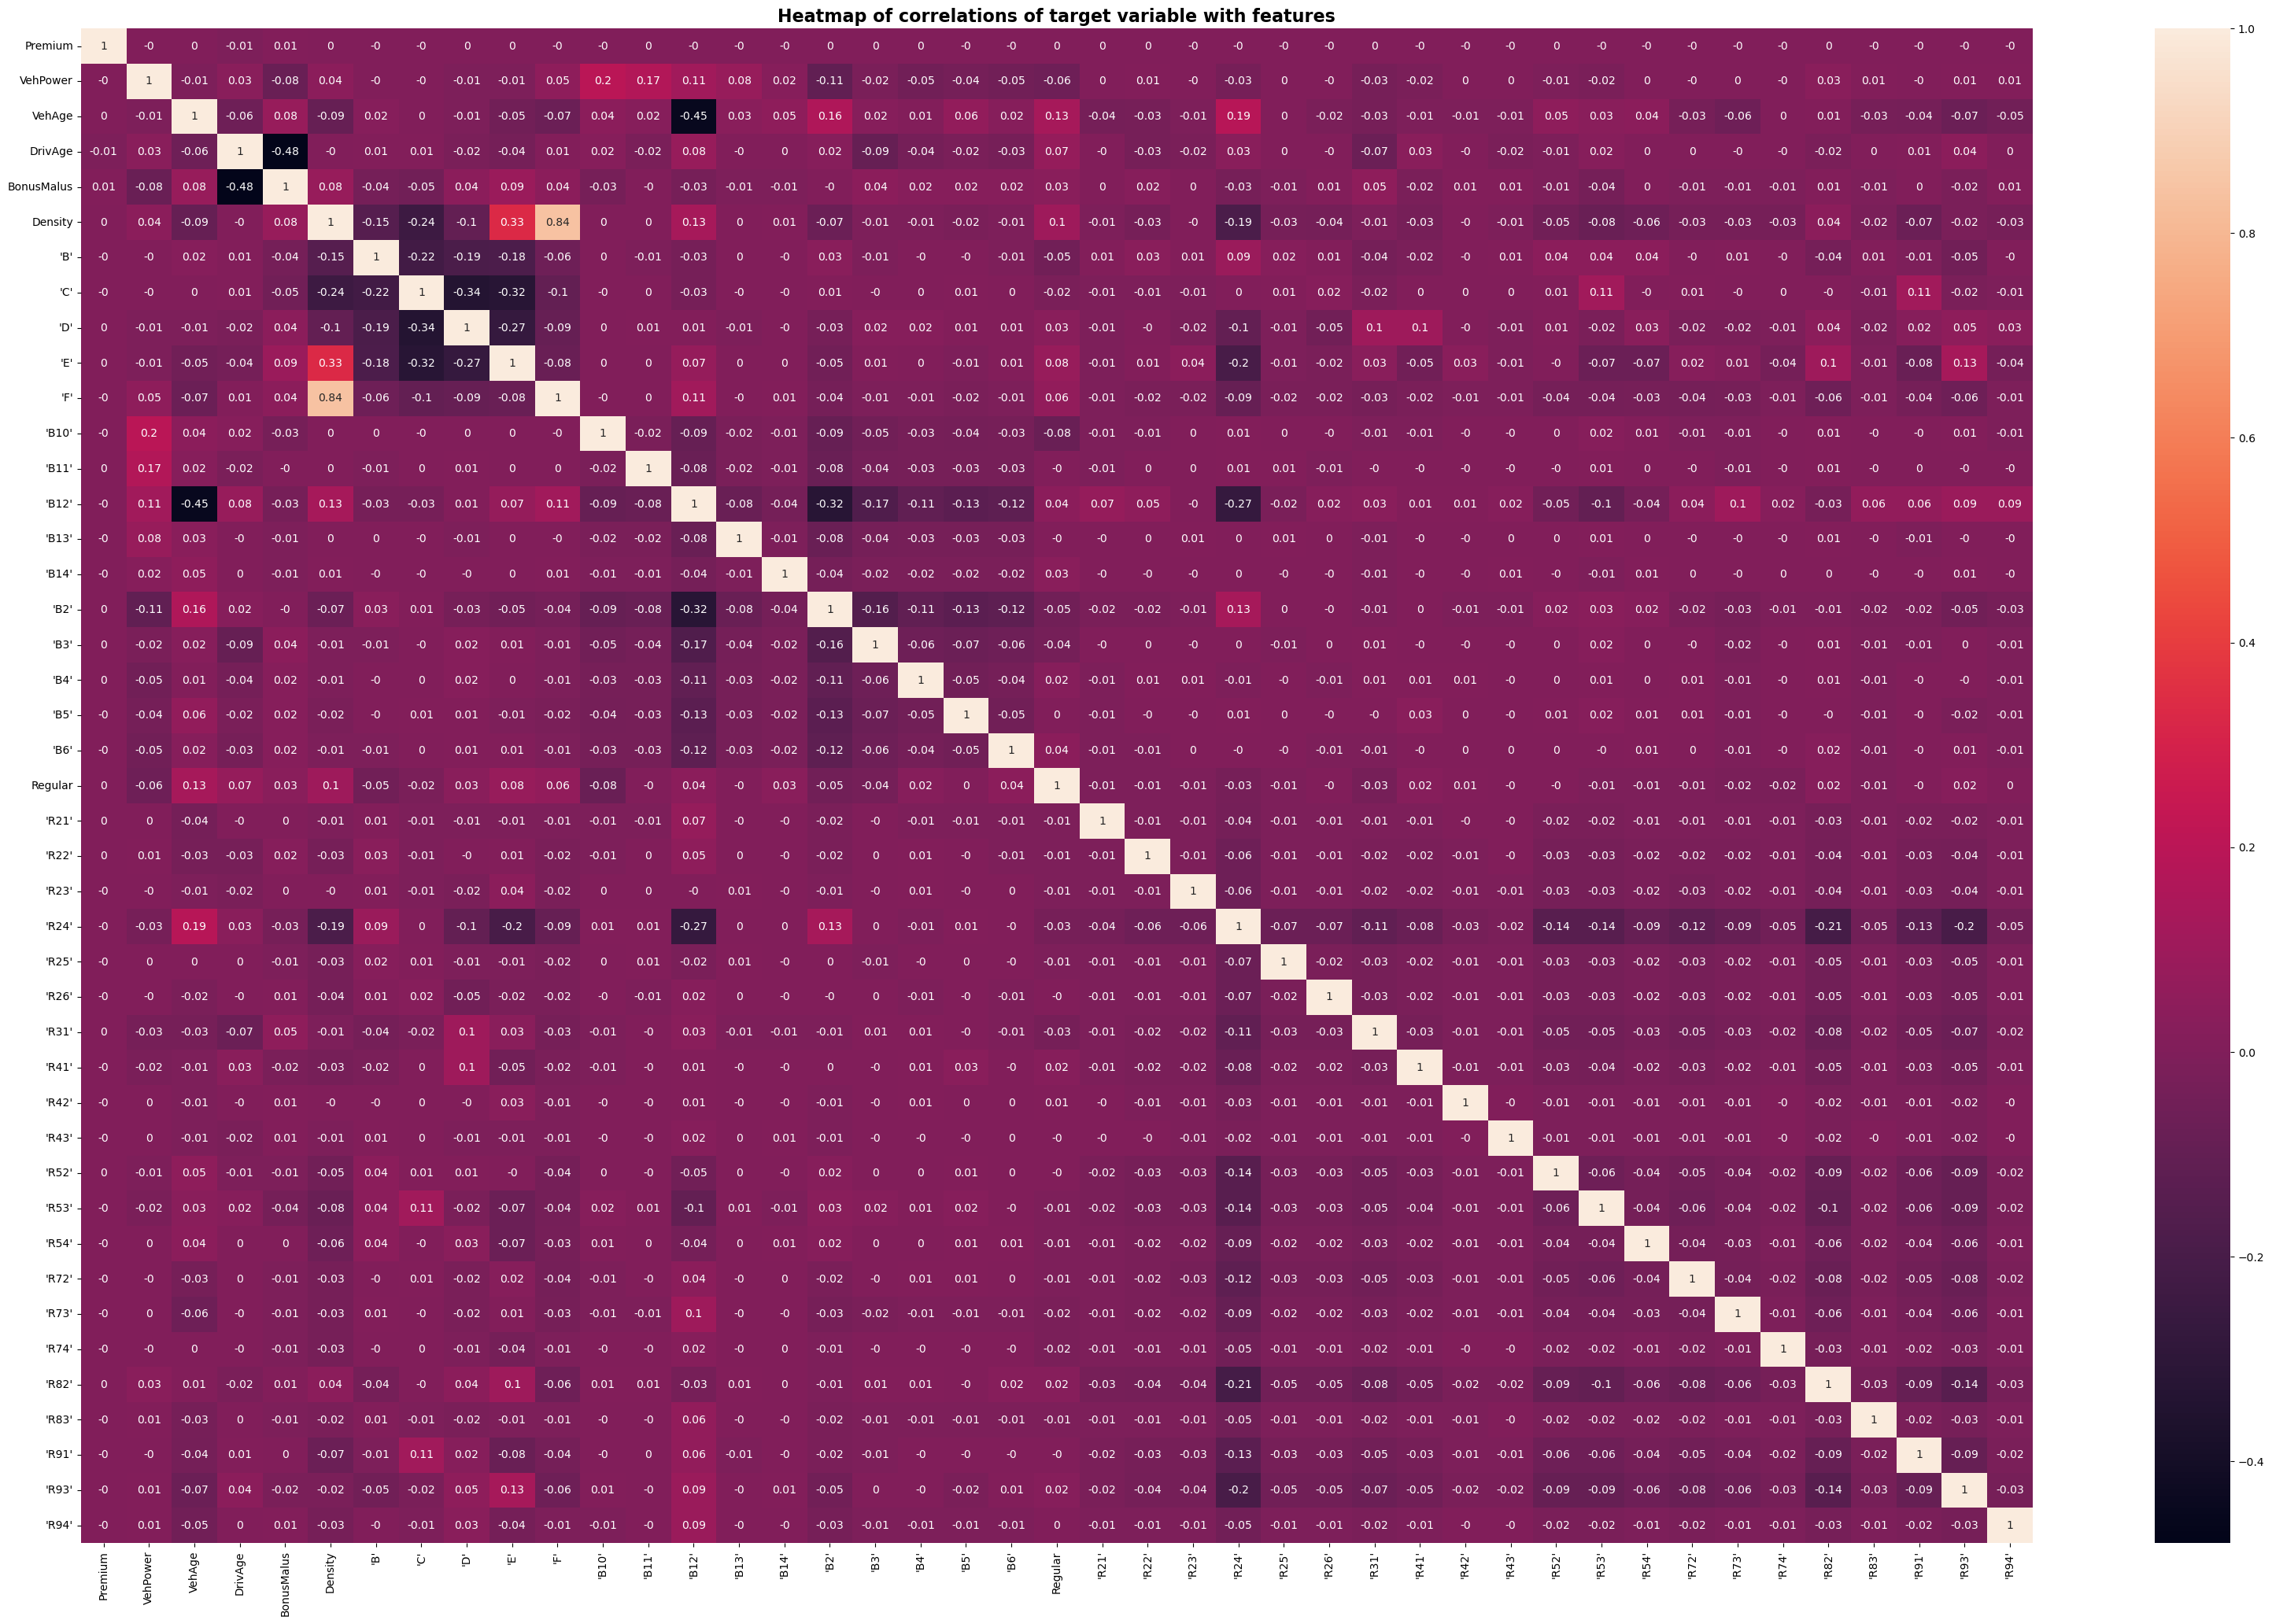

In [63]:
# check the correlations of the target variable and all features:
fig,ax = plt.subplots(nrows =1, ncols = 1, figsize = (40,25))
corr1 = df1.corr(method='pearson', min_periods=1)
sns.heatmap(round(corr1,2), annot = True, annot_kws={"fontsize":10})
plt.title('Heatmap of correlations of target variable with features', fontsize=16, weight = 'bold')
plt.setp(ax.get_xticklabels(), fontsize=10, weight = 'normal');
plt.setp(ax.get_yticklabels(), fontsize=10, weight = 'normal');
plt.show()

Consider removing or adjusting feature 'Area' due to high correlations with feature 'Density'. For now all features are considered.

In [97]:
# Split the data into training and test observations:
X_train, X_test, y_train, y_test, X_val, y_val = get_split(df1, test_size = 0.3)

###  Tune, train and predict the model

In [230]:
TUNE = 0 # tune the models?
LOAD = 1 # load previously trained model?
x_vars_show = ['DrivAge', 'BonusMalus','Density','VehAge'] # feature to plot the fit of a model for. 
Y_TRANSFORM = '' # '' or 'log' transform the dependent variable for RF and GBM

# initialize the result data sets:
res_stats_train = pd.DataFrame()
res_stats_test  = pd.DataFrame()


For the hyperparameter tuning, we use a three-fold cross-validation on the training data set with 40 parameter settings sampled from random search. 
Random search can cover a larger area of the parameter space with the same number of consider setting compared to e.g. grid search.

In [231]:
# reload functions from utility
reload(sys.modules['utility'])
from utility import *

#### Gradient boosting regression

Gradient boosting is one of the most powerful techniques for building predictive models using ensembler of weak prediction models.
We use the traditional gradient boosting decision tree as boosting type.

In [232]:
# tune and train the GBM model:
gbm_model = train_model(X_train, y_train, df, model_type = 'lgbm', TUNE = TUNE, output_folder_model = output_folder_model, LOAD =LOAD, X_val = X_val, y_val = y_val, Y_TRANSFORM=Y_TRANSFORM)

In [233]:
# Get error statistics of the predictions and observations of the in-sample data set:
res_stats_train['GBM']  = error_statistics(y_train, gbm_model.predict_y(X_train), df)
# Get error statistics of the predictions and observations of the hold-out period:
res_stats_test['GBM'] =  error_statistics(y_test, gbm_model.predict_y(X_test), df)

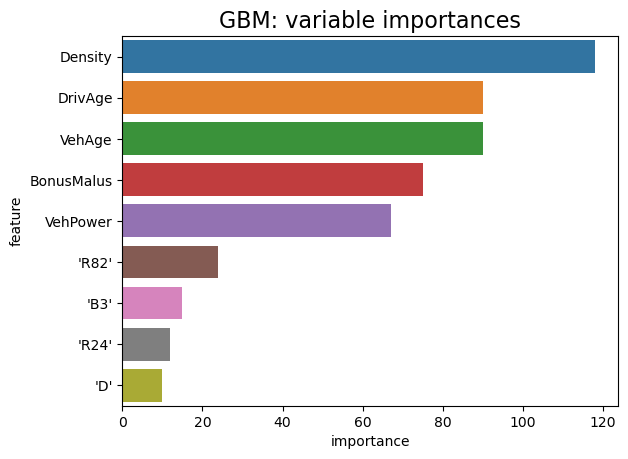

In [234]:
# plot model results:
plot_model_results(gbm_model, title2 = 'GBM: variable importances')

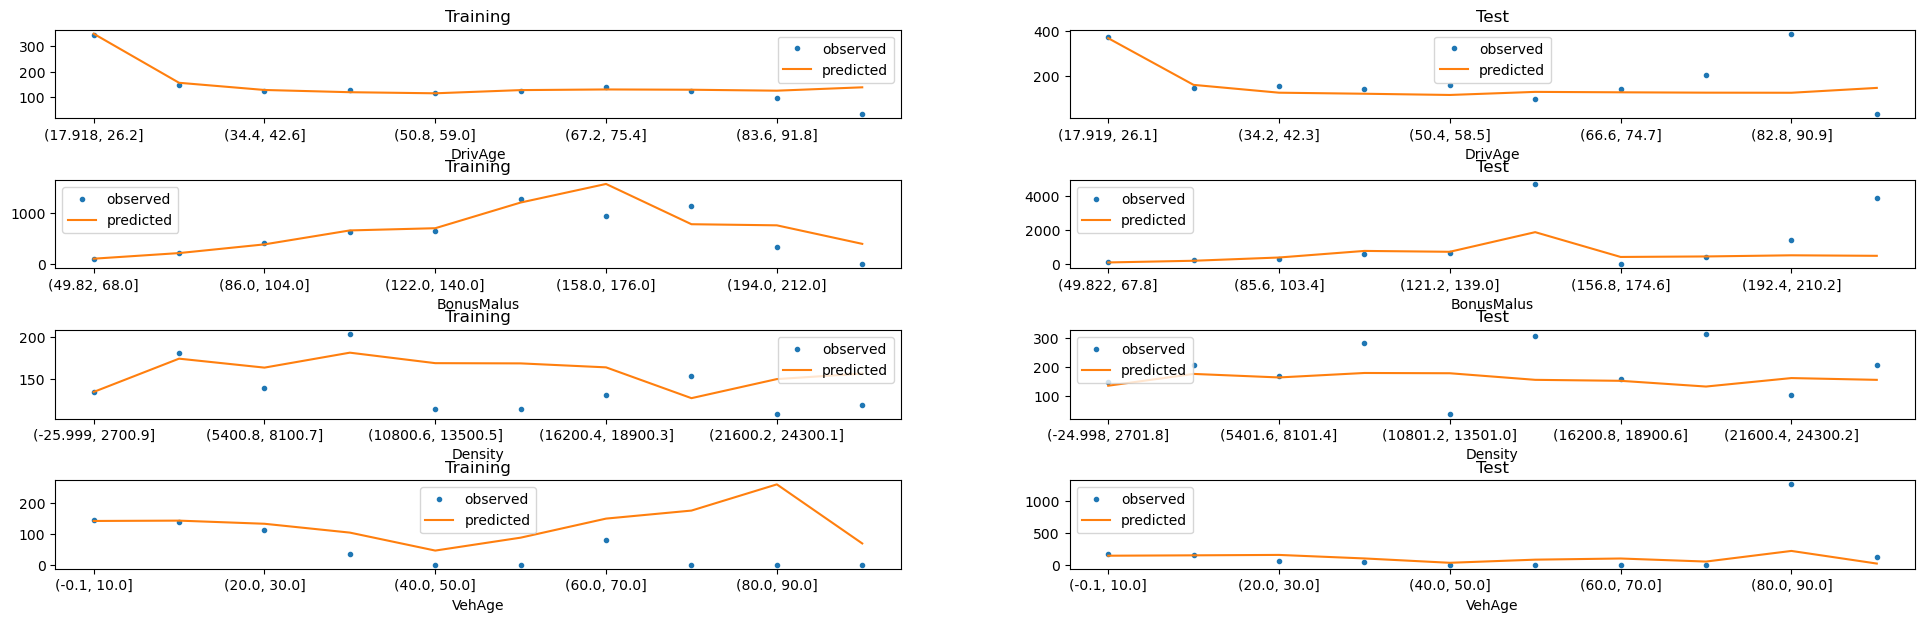

In [235]:
# plot fit according to aggregated feature values:
plot_feature_fit(gbm_model, df, X_train, X_test, x_vars_show)

#### Random Forest Model

Random Forest (RF) variant that use a gradient boosting model with random forest as boosting type and a bagging fraction of 80% at each iteration (i.e., a bagging frequency of 1). Use allow of a feature fraction less than one and for a learning rate of one (the same as in a standard RF model).

See, e.g., here for details how gradient boosting can be used to train a RF model (at the example of the XGBoost algorithm): https://xgboost.readthedocs.io/en/latest/tutorials/rf.html 

In [236]:
# tune and train the model:
rf_model = train_model(X_train, y_train, df, model_type = 'rf', TUNE = TUNE, output_folder_model = output_folder_model, LOAD =LOAD, X_val = X_val, y_val = y_val, Y_TRANSFORM=Y_TRANSFORM)

In [237]:
# Get error statistics of the predictions and observations of the in-sample data set:
res_stats_train['RF'] = error_statistics(y_train, rf_model.predict_y(X_train), df)
# Get error statistics of the predictions and observations of the hold-out period:
res_stats_test['RF'] = error_statistics(y_test, rf_model.predict_y(X_test), df)

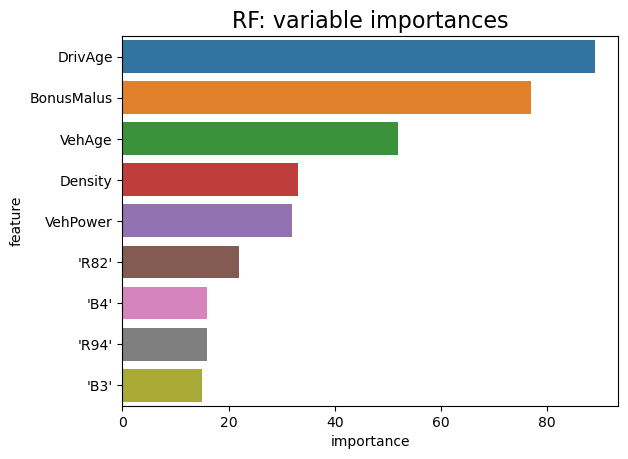

In [238]:
# plot model results:
plot_model_results(rf_model, title2 = 'RF: variable importances')

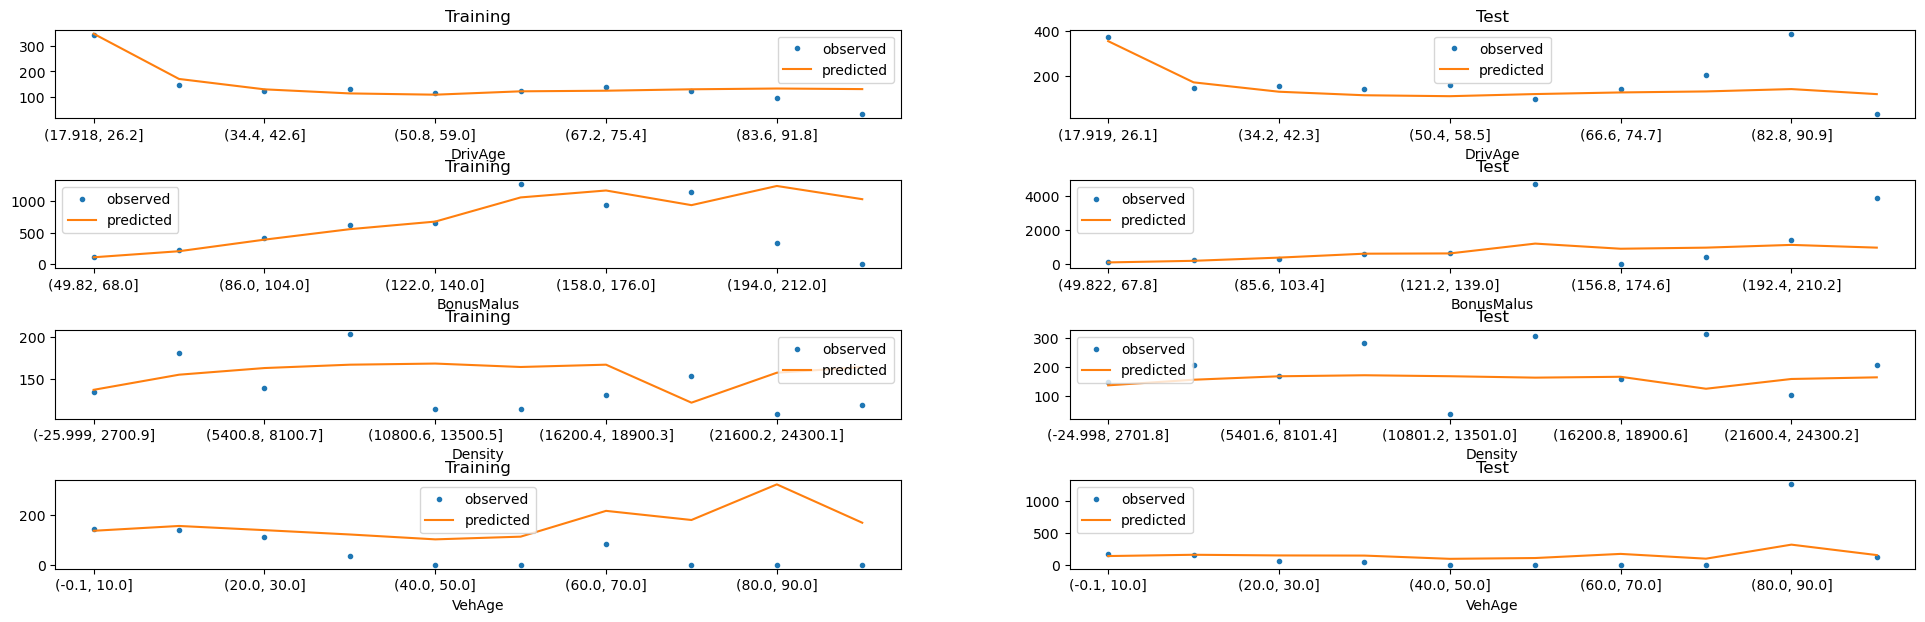

In [239]:
# plot fit according to aggregated feature values:
plot_feature_fit(rf_model, df, X_train, X_test, x_vars_show)

#### Generalized linear model with Tweedie distribution

The Tweedie distribution is a special case of an exponential distribution. The Tweedie distribution can the shape of a distribution with mass on the zero and with a second (skewed) bell-shaped mass area with a non-zero mode. This is, a similar shape as Preimum (log-transformed). Therefore, a Generalized linear model (GLM) with a Tweedie distribution (with log-link) might be well suited for regression task.

The GLM with a Tweedie distribution can be used to model different GLMs depending on the power parameter, which determines the underlying distribution.


| Power         | Distribution     
|--------------|-----------|
| 0| Normal     | 
| 1      | Poisson | 
| (1,2)      | Compound Poisson Gamma | 
| 2      | Gamma | 
| 3      | Inverse Gaussian | 


See, e.g., here for more general information about the Tweedie distribution https://en.wikipedia.org/wiki/Tweedie_distribution.

In [240]:
# Tweedie Regressor
glm_tr = train_model(X_train, y_train, df, TUNE = TUNE, output_folder_model = output_folder_model, LOAD =LOAD)

In [241]:
# Get error statistics of the predictions and observations of the in-sample data set:
res_stats_train['GLM']  = error_statistics(y_train, glm_tr.predict_y(X_train), df)
# Get error statistics of the predictions and observations of the hold-out period:
res_stats_test['GLM'] = error_statistics(y_test,  glm_tr.predict_y(X_test), df)

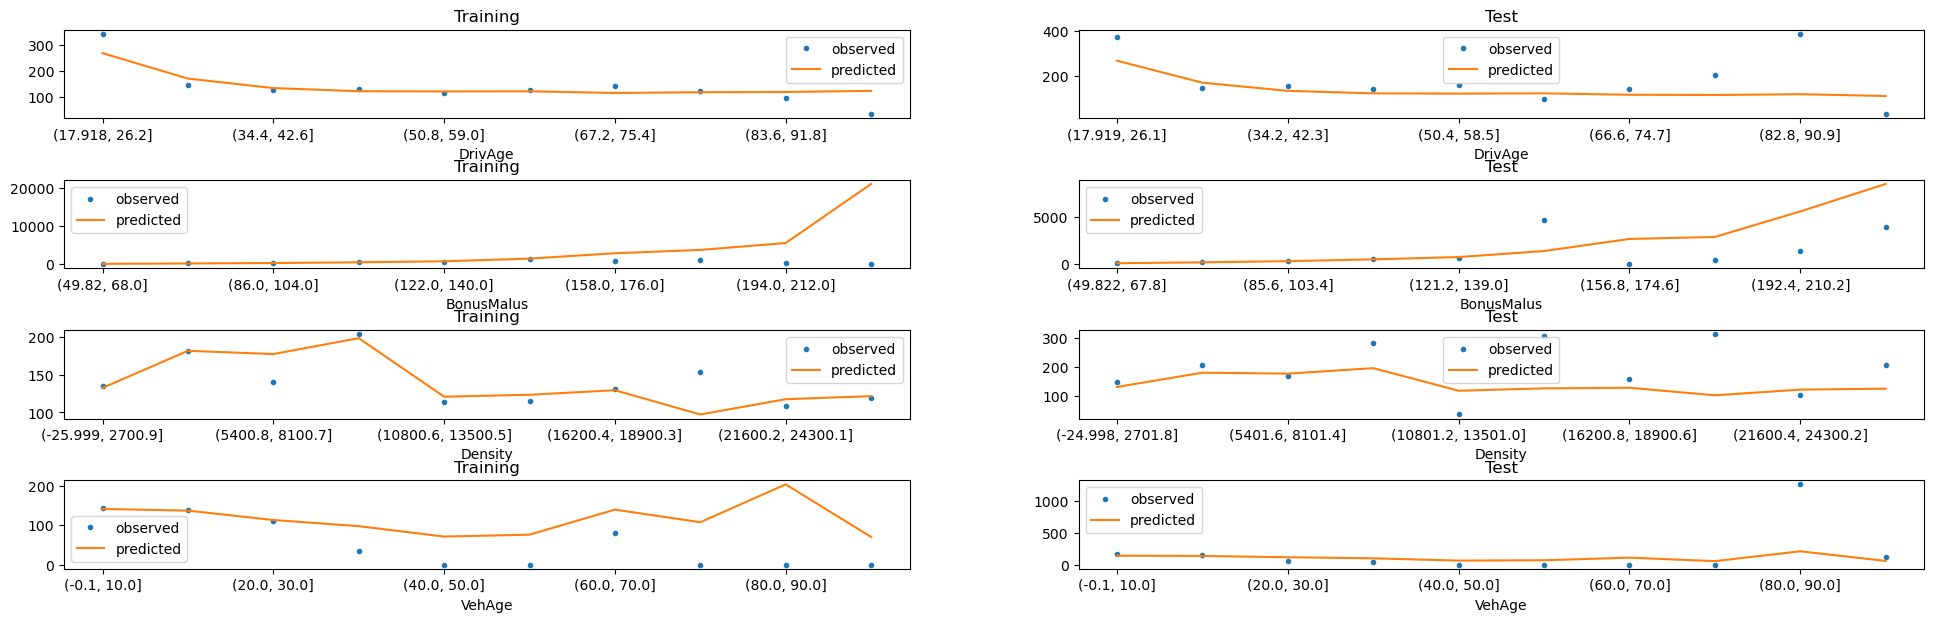

In [242]:
# plot fit according to aggregated feature values:
plot_feature_fit(glm_tr, df, X_train, X_test, x_vars_show)

#### Gradient boosting regression with Tweedie distribution

We can combine the GBM regression with a Tweedie distribution (with log-link), similar to a GLM.

In [243]:
# tune and train the GBM model:
gbm_tw_model = train_model(X_train, y_train, df, model_type = 'lgbm_tw', TUNE = TUNE, output_folder_model = output_folder_model, LOAD =LOAD, X_val = X_val, y_val = y_val, Y_TRANSFORM=Y_TRANSFORM)

In [244]:
# Get error statistics of the predictions and observations of the in-sample data set:
res_stats_train['GBM-TW']  = error_statistics(y_train, gbm_tw_model.predict_y(X_train), df)
# Get error statistics of the predictions and observations of the hold-out period:
res_stats_test['GBM-TW'] =  error_statistics(y_test, gbm_tw_model.predict_y(X_test), df)

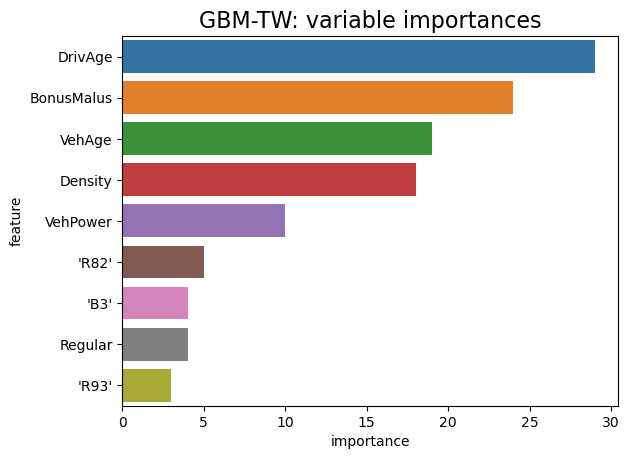

In [245]:
# plot model results:
plot_model_results(gbm_tw_model, title2 = 'GBM-TW: variable importances')

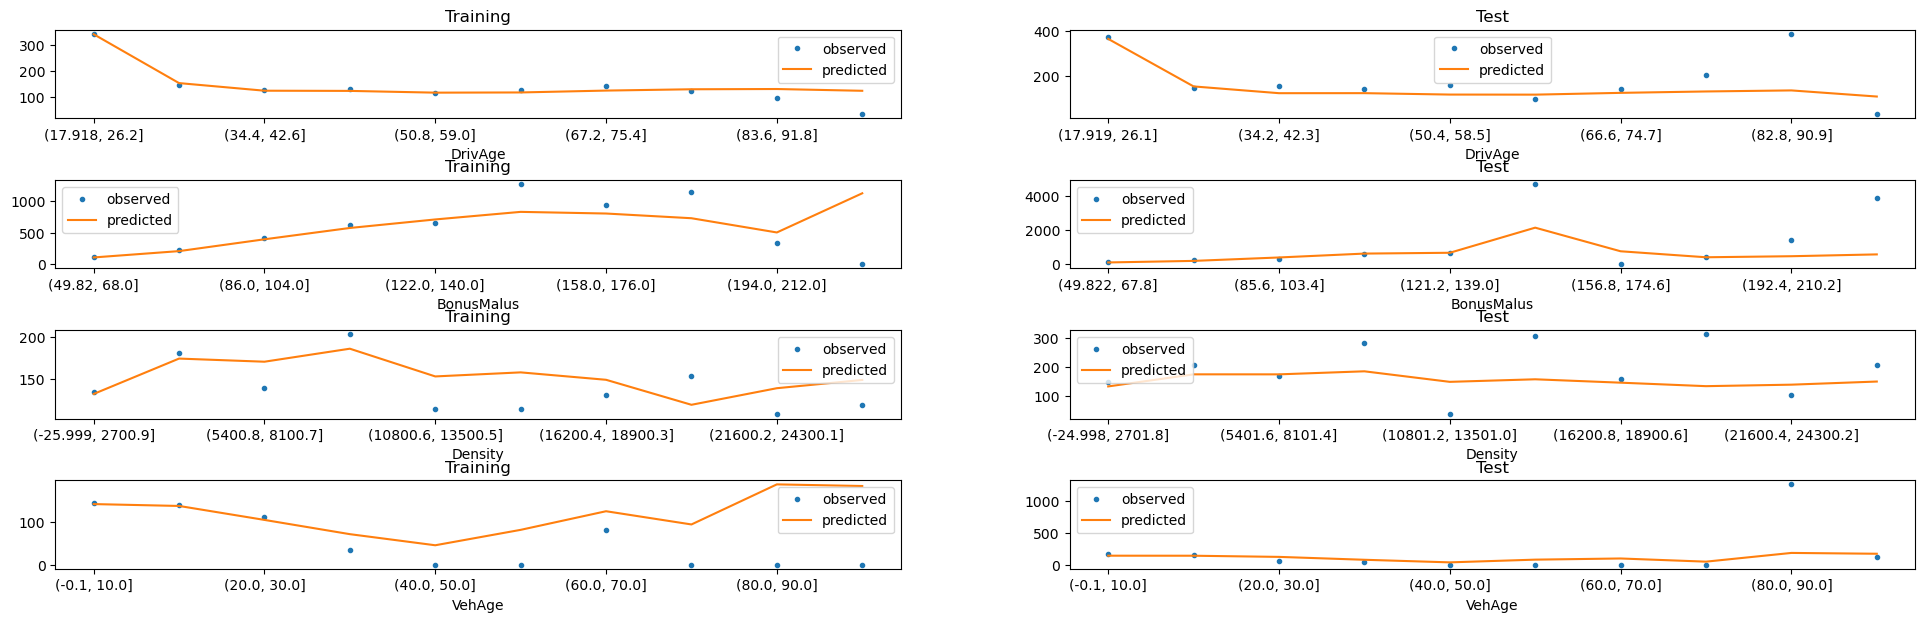

In [246]:
# plot fit according to aggregated feature values:
plot_feature_fit(gbm_tw_model, df, X_train, X_test, x_vars_show)

#### Show the in-sample error statistics

In [247]:
# adjust display settings:
pd.options.display.float_format =  '{:,.1f}'.format
res_stats_train

,GBM,RF,GLM,GBM-TW
Root mean squared error,"12,854.5","12,922.4","12,946.3","12,930.8"
Mean absolute error,438.7,434.3,428.9,431.9
Total observed ClaimAmount,"35,504,746.9","35,504,746.9","35,504,746.9","35,504,746.9"
Total predicted ClaimAmount,"35,504,746.9","35,429,832.7","35,157,655.8","35,020,656.6"
Percentage error total ClaimAmount,0.0,-0.2,-1.0,-1.4


#### Show the out-of-sample error statistics

In [248]:
res_stats_test

,GBM,RF,GLM,GBM-TW
Root mean squared error,"47,497.5","47,491.2","47,489.7","47,490.9"
Mean absolute error,620.6,609.6,602.9,607.9
Total observed ClaimAmount,"17,357,422.2","17,357,422.2","17,357,422.2","17,357,422.2"
Total predicted ClaimAmount,"15,378,857.3","15,253,172.1","15,058,182.0","15,163,962.1"
Percentage error total ClaimAmount,-11.4,-12.1,-13.2,-12.6


Model performance is overall similar in terms of RMSE, MAE and percentage recovered total ClaimAmount in the test set. 

In [249]:
# reset display settings
pd.reset_option('^display.', silent=True)

#### How well do models rank clients according to their risk?  

Ordered Lorenz curve of models:

X-axis: Rank clients from safest to riskiest based on model's predictions. 

Y-axis: Fraction of observed total cumulated claims.



Gini coefficient: 

Bases on the area between the curve and the diagonal (with outcomes between 0 and 1.)


Note these analyses do not reflect the ability of the models to make accurate predictions in terms of absolute value of total claim amounts but only in terms of relative amounts as a ranking metric. 

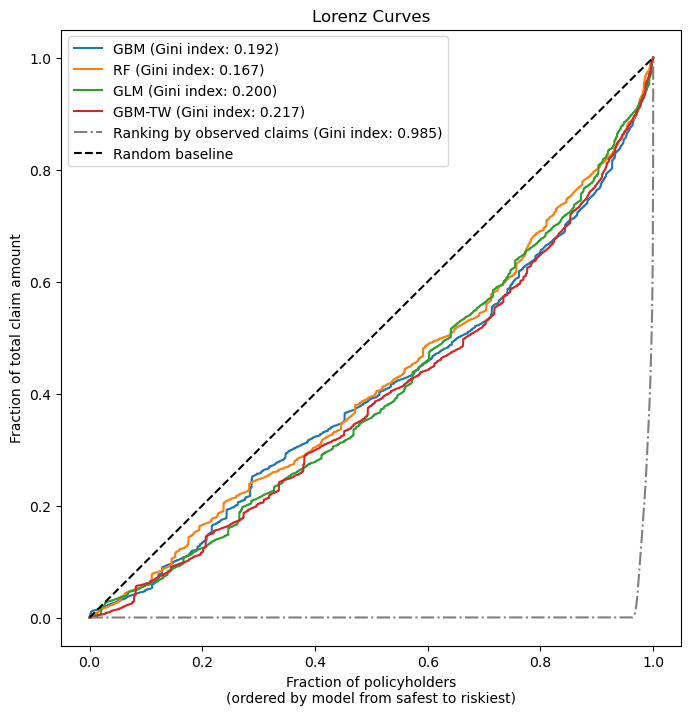

In [250]:
# show lorenz curves and get gini indices:
show_lorenz_curves(df, X_test, gbm_model, rf_model, glm_tr, gbm_tw_model)    

All models rank the clients far better than a random ranking with a slight benefit of the GBM and GLM models. However, the rankings also far from a 'perfect' ranking.

 Note that car liability insurance incidents presumably are mainly caused by car accidents. Whether an accident occurs and how severe the caused damage may be depend on random factors in general and might be associated to the environment of claim events, such as date, day of week, time of day, speed, the condition of the driver, the place and etc. This circumstance give an intuition why the models might not predict the premium in more depth with the given information.

## Future refinements

- Refine models in terms of tuning and specifications (e.g. regarding variable transformations and feature engineering, such as combination of categories of categorial variables)
- Consider two step model, e.g.: 1. Model the number of Claims and 2. Model the claim amount in case of a claim. 
- Consider a GLM GAM to allow for more flexible effects
- Consider a deep learning model
- Possibly add demographic variables, such as, HH size, number of kids and income
- Possibly add number of adults driving the car